# Loan status prediction
##### This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction)
For further detail refer to *descriptive_analysis.ipynb* or *pre_modelling_process.ipynb* notebooks

In [2]:
import sys
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The following process was conducted carefully in *pre_modelling_process.ipynb* notebook and enhanced in the current one. Refer to the former for further detail

In [12]:
# Load the imputed data
df = pd.read_csv("loan_data_imp.csv") 
####################################################################################################
# Recode variables:
df['Married'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Education'] = df['Education'].replace({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Married'].replace({'Yes': 1, 'No': 0})
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})

####################################################################################################
# Import methods to transform categorical features 
# Many methods do not work with object/string type features and thus these must be recoded
from sklearn.compose import ColumnTransformer
# Categorical features will be recoded using an ordinal encoder for further sequential feature selection
from sklearn.preprocessing import OrdinalEncoder

numerical_features = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
columns_to_keep_same = []
columns_to_keep_same.extend(numerical_features)
columns_to_keep_same.extend(['Loan_ID'])

categorical_features = df.columns.difference(columns_to_keep_same).tolist()

# Create a ColumnTransformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without any transformation
)

# The preprocessor will return the transformed data with a different column order from the original df
# Later I will turn the np.array into a pd.DataFrame and for that I need the right column order
import re
# First get the feature names ordered from the preprocessor
preprocessor_feature_names = preprocessor.fit(df).get_feature_names_out()

# Clean the "cat__" and "remainder__" prefixes
cleaned_feature_names = [re.sub(r'^(cat__|remainder__)', '', name) for name in preprocessor_feature_names]

# Transform the data
df = preprocessor.fit_transform(df)
df = pd.DataFrame(df, columns = cleaned_feature_names)
####################################################################################################
# Import the MinMaxScaler from the preprocessing module of sklearn
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns = numerical_features)
# Now combine the non-numerical features data with the normalised features
df_norm = df.drop(numerical_features, axis = 1).join(df_norm)

####################################################################################################
# Import the train_test_split function from the model_selection module
from sklearn.model_selection import train_test_split

df.sample(frac = 1, random_state = 25).reset_index(drop = True)

# Split approved loan data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Loan_Status', 'Loan_ID'], axis = 1), df['Loan_Status'], 
                                                    test_size = 0.2, random_state = 25, stratify = df['Loan_Status']) 
# with stratify = df['Loan_Status'] assures that we keep 71% approved and 29% rejected for both train and test sets
# Repeat the process for normalised data
df_norm.sample(frac = 1, random_state = 25).reset_index(drop = True)

X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(df_norm.drop(['Loan_Status', 'Loan_ID'], axis = 1), 
                                                            df_norm['Loan_Status'], 
                                                            test_size = 0.2, random_state = 25, 
                                                            stratify = df_norm['Loan_Status']) 
# We write y_n_train and y_n_train to avoid error messages, but we will only use y_train and y_test as they are exactly the same
####################################################################################################
# Lastly, recode the response 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

####################################################################################################
# Create subset of features according to the results Feature Importance Analysis

X_train_sub = X_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
X_test_sub = X_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

X_n_train_sub = X_n_train.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)
X_n_test_sub = X_n_test.drop(['Education', 'Married', 'Gender', 'Self_Employed'], axis = 1)

## Model fitting process

### 1. Logistic Regression
When using logistic regression models, we must use the normalised/standardise features

In [9]:
# Import module with model
from sklearn import linear_model as lm

# Import methods to test model's perfrormance
from sklearn.metrics import classification_report, confusion_matrix

# Import method for feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Import method for cross validation and hyperparameter tunning 
from sklearn.model_selection import cross_val_score, GridSearchCV

In [10]:
# Load the Logistic Regression model
logreg = lm.LogisticRegression(solver = 'liblinear', random_state = 25)

In [13]:
# Fit the model including all features
logreg_model_all = logreg.fit(X = X_n_train, y = y_train)
print(logreg_model_all.score(X_n_test, y_test))

0.8181818181818182


In [14]:
# Fit the model including only relevant features
logreg_model_rel = logreg.fit(X = X_n_train_sub, y = y_train)
print(logreg_model_rel.score(X_n_test_sub, y_test))

0.8181818181818182


In [16]:
# Fit the model using cross-validation
print(cross_val_score(logreg, X_n_train_sub, y_train, cv = 25).mean())

0.8515384615384616


In [18]:
# Now let's aim for hyperparameter tunning
from sklearn.pipeline import Pipeline
pipe = Pipeline([("classifier", lm.LogisticRegression(solver = "liblinear"))])

# solver = "liblinear" works fine for small datasets such as the current

search_space = [
    {"classifier" : [lm.LogisticRegression(solver = "liblinear")],
     "classifier__penalty" : ["l1", "l2"],
     "classifier__max_iter" : [500, 1000],
     "classifier__C" : [0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]}
]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0, n_jobs = -1)

In [20]:
logreg_best = clf.fit(X_n_train_sub, y_train)
print(logreg_best.best_estimator_.get_params()["classifier"])

LogisticRegression(C=0.1, max_iter=500, penalty='l1', solver='liblinear')


After testing the sets of hyperparameters above, the conclusion is that the best hyperparameters for a logistic regression model with "liblinear" solver are with penalty L1 (Ridge) and C = 0.1, that is quite a strong regularization. A top of 500 iterations was enough, meaning that we did not get any issues with convergence (as expected given the dataset size and the number of features included in the model).

#### Model evaluation
In this stage we will evaluate the model's performance through different measures and indicators that quantify the predictive capabilities of the model.

- Confusion Matrix: The confusion matrix presents a tabular summary of the model's performance by comparing predicted class labels with the true class labels. It consists of four terms:
    - True Positive (TP): The model predicted the positive class correctly.
    - True Negative (TN): The model predicted the negative class correctly.
    - False Positive (FP): The model predicted the positive class incorrectly.
    - False Negative (FN): The model predicted the negative class incorrectly.

- Accuracy: Accuracy is the most commonly used metric, representing the overall correctness of the model's predictions. It is calculated as (TP + TN) / (TP + TN + FP + FN).

- Precision: Precision measures the model's ability to correctly predict the positive class. It is calculated as TP / (TP + FP). Precision is useful when the cost of false positives is high.

- Recall (Sensitivity/True Positive Rate): Recall quantifies the model's ability to correctly identify the positive class instances. It is calculated as TP / (TP + FN). Recall is important when the cost of false negatives is high.

- Specificity: Specificity measures the model's ability to correctly identify the negative class instances. It is calculated as TN / (TN + FP). Specificity is important when the cost of false positives is high.

- F1 Score: The F1 score combines precision and recall into a single metric. It is the harmonic mean of precision and recall and provides a balanced measure. The F1 score is calculated as 2 * (Precision * Recall) / (Precision + Recall).

Additionaly we will explore different probability thresholds that result in more adecuate outcomes for the business, i.e. that the false positive are very low, if not null. Recall that it is very important to avoid approving loans to people who will not be able to pay them. That would result in major losses for the company.
Scikit-learn uses the probability threshold as P>=0.5

In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay

In [23]:
# Make predictions on the test set
y_pred = logreg_best.predict(X_n_test_sub)
y_prob = logreg_best.predict_proba(X_n_test_sub)#[:, 1]

In [37]:
logreg_precision_score = precision_score(y_test, y_pred)
logreg_recall_score = recall_score(y_test, y_pred)
logreg_roc_auc_score = roc_auc_score(y_test, y_pred)
logreg_f1_score = f1_score(y_test, y_pred)

print('Logistic regression presicion score: ' + str(round(logreg_precision_score,3)))
print('Logistic regression recall score: ' + str(round(logreg_recall_score,3)))
print('Logistic regression ROC score: ' + str(round(logreg_roc_auc_score,3)))
print('Logistic regression F1 score: ' + str(round(logreg_f1_score,3)))

Logistic regression presicion score: 0.797
Logistic regression recall score: 1.0
Logistic regression ROC score: 0.682
Logistic regression F1 score: 0.887


(0.0, 1.0)

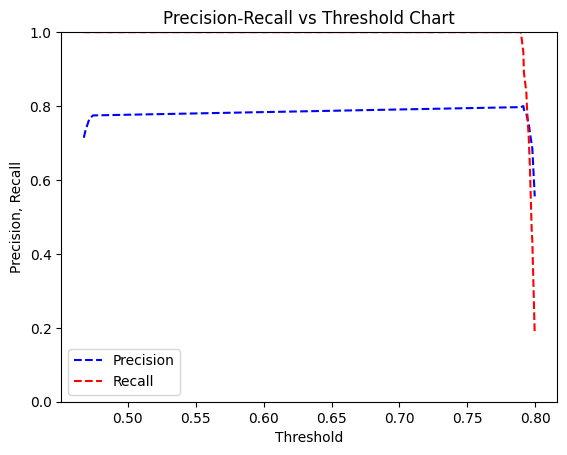

In [39]:
# Precision-Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob [:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

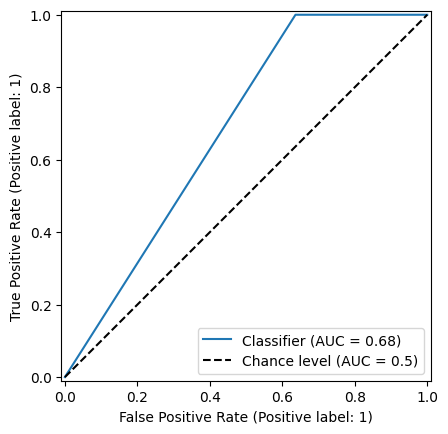

In [41]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level = True)

Basically we have an increasingly false positive rate along we get a higher true positive rate. That is, if we want to get a reasonable amount of true positives, we will also get higher false positives very easily. 

In [44]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[ 8, 14],
       [ 0, 55]], dtype=int64)

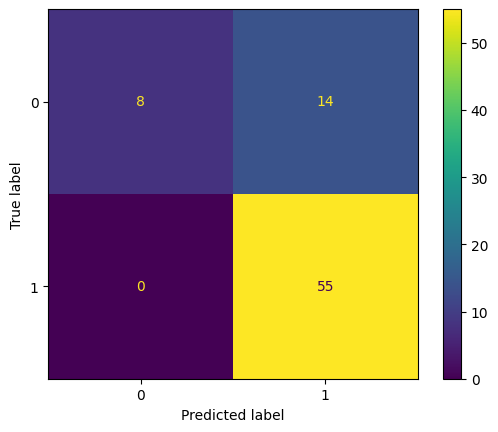

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), 
                       display_labels = logreg_best.classes_)
disp.plot()
plt.show()

The logistic regression model performed poorly to correctly predict the rejected loans. Plenty loans from the test set should have been rejected while they were approved (14 out of 22). We could say that the model is *over-approving*. This is also noticeable when looking at the true positives, that is, the loans predicted as approved which were actually approved (100%)
Moreover when testing different thresholds to make the model more rigurous, the precision reaches 0.8 and then falls rapidly. 

We should aim for a more conservative approach, that is, one that, at least, rejects more applications. 

### 2. Decision Tree Classifier
For the decision tree classifier we do not need to transform the data. We can simply use the original data

In [49]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 25)

cross_val_score(tree, X_train_sub, y_train, cv = 10).mean()


0.8089247311827956

In [50]:
# Now let's aim for hyperparameter tunning
from sklearn.pipeline import Pipeline
pipe = Pipeline([("classifier", DecisionTreeClassifier(random_state = 25))])

# solver = "liblinear" works fine for small datasets such as the current

search_space = [
    {"classifier" : [DecisionTreeClassifier(random_state = 25)],
     "classifier__criterion" : ["gini", "entropy", "log_loss"],
     "classifier__max_depth" : list(range(1,10))
    }
]

clf = GridSearchCV(pipe, search_space, cv = 10, verbose = 0, n_jobs = -1)

In [51]:
tree_best = clf.fit(X_train, y_train)
print(tree_best.best_estimator_.get_params()["classifier"])

DecisionTreeClassifier(max_depth=1, random_state=25)


In [52]:
tree_best = tree.fit(X_train, y_train)
y_pred = tree_best.predict(X_test)

tree_best.score(X_test, y_test)

0.8051948051948052